# Fast Force Field Fitting (F4) EXESS based data generation with a SMIRNOFF force field fit

In this notebook we'll generate all of the QM data required to fit a force fields from EXESS (using the F4 data generation module) and then we will fit a SMIRNOFF type forcefield (using the F4 smirnoff fit module)

# 0) Complete example

See the sample notebook for a complete demonstration.

# 1) Setup

## 1.0) Imports

In [2]:
import json
import os
from pathlib import Path
import py3Dmol
import time
import IPython.display
import matplotlib.pyplot as plt

import rush

## 1.1) Configuration

In [4]:
EXPERIMENT = "rush-py f4 fitting demo"
SYSTEM = "GLYCINE"
TAGS = ["qdx", EXPERIMENT, SYSTEM]

In [5]:
# |hide
WORK_DIR = Path.home() / "qdx" / EXPERIMENT

if WORK_DIR.exists():
    client = rush.Provider(workspace=WORK_DIR)
    await client.nuke(remote=False)

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(WORK_DIR / ".rush", exist_ok=True)
YOUR_TOKEN = os.getenv("RUSH_TOKEN")
os.chdir(WORK_DIR)

Build our client

In [6]:
os.environ["RUSH_TOKEN"] = YOUR_TOKEN

client = rush.build_blocking_provider_with_functions(batch_tags=TAGS)

Bad type! 1
Bad type! 0
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 4
Bad type! 5
Bad type! 6
Bad type! 250
Bad type! 251
Bad type! 252
Bad type! 253
Bad type! 254
Bad type! 255
Bad type! 0
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 4
Bad type! 5
Bad type! 6
Bad type! 250
Bad type! 251
Bad type! 252
Bad type! 253
Bad type! 254
Bad type! 255
Bad type! 1
Bad type! 1
Bad type! 2
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 7
Bad type! 8
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 7
Bad type! 8
Bad type! 1
Bad type! 2
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad 

# 2) Preparation

## 2.1) QDXF input file

In [7]:
glycine_data = {
  "schema_version": "0.2.0",
  "geometry": [
    2.8315369813193936, -0.012276482655411019, -0.04420729297091298,
    2.0438584571382803, -0.3647395765421934, 0.5225107506788758,
    0.7986260557797081, 0.16232294621286594, 0.19982508170048197,
    0.7729295964771392, 1.3542568149628207, -0.18611420167642995,
    -0.45079196027516766, -0.5979484620124086, 0.2900217249171123,
    -1.2895410761554387, -0.08506625020890618, -0.2641130923373958,
    -0.7717366906036721, -0.7701304047747469, 1.3588383430620818,
    -0.25972755986510376, -1.9071847571482659, -0.2820847414426759,
    -0.6093307740571089, -1.9888247661570349, -1.2621106958515207,
    0.7462059815469474, -2.225070961683621, -0.24739224505533192
  ],
  "symbols": ["H", "O", "C", "O", "C", "H", "H", "N", "H", "H"]
}
qdxf_input = Path(WORK_DIR) / "glycine_input.qdxf.json"
with open(qdxf_input, "w") as f:
    json.dump(glycine_data, f)

# 3) F4 Data Generation

To fit a force field we first generate the QM data

## 3.0) Arguments to F4 data generation

In [8]:
help(client.f4_data_generation)

Help on function f4_data_generation in module rush.provider:

f4_data_generation(*args: typing_extensions.Unpack[tuple[Record, RushObject[Record]]], target: 'Target | None' = None, resources: 'Resources | None' = None, tags: 'list[str] | None' = None, restore: 'bool | None' = None) -> tuple[RushObject[Record]]
    generate torsional energy profiles for input molecules
    
    Module version:  
    `github:talo/F4/82071637cf6aab198594ddd743d4193f214e0944#f4_data_generation_tengu`
    
    QDX Type Description:
    
        in: F4DataGenerationParameters {
            basis_set: string,
            fragment_torsion_jobs: bool,
            grid_spacing_deg: u32,
            use_rihf: bool,
            use_rimp2: bool,
            clear_working_directory: bool
        };
        in: Object {
            format: ObjectFormat[json | bin]?,
            path: @Topology {
                fragment_partial_charges: [_(f32)]?,
                geometry: [f32],
                connectivity: [_(
   

## 3.1) Running F4 data generation

In [9]:
F4_RESOURCES = {
    "gpus": 1,
    "storage": 1000,
    "storage_units": "MB",
    "walltime": 60,
}

In [10]:
(f4_data,) = client.f4_data_generation(
  {
    "basis_set": "STO-3G",
    "use_rihf": True,
    "use_rimp2": False,
    "fragment_torsion_jobs": True,
    "grid_spacing_deg": 15,
    "clear_working_directory": True
  },
  qdxf_input,
  resources=F4_RESOURCES,
)

In [12]:
f4_data = json.load(f4_data.download(filename="data.json", overwrite=True).open())

AttributeError: 'dict' object has no attribute 'download'

## 3.2) Visualise the F4 data

In [13]:
def create_xyz_data(coords, symbols):
    xyz_data = f"{len(symbols)}\n\n"
    for i, (x, y, z) in enumerate(coords):
        xyz_data += f"{symbols[i]} {x} {y} {z}\n"
    return xyz_data

In [14]:
xyz_for_angle = {}
energy_for_angle = {}
for torsion_data in f4_data["dihedral_data"][0]:
    angle = torsion_data["angle"]
    xyz_for_angle[angle] = create_xyz_data(
        torsion_data["optimised_geometry"]["coords"], torsion_data["optimised_geometry"]["symbols"]
    )
    energy_for_angle[angle] = torsion_data["energy"]

Text(0.5, 1.0, 'Energy Profile for Dihedral Scan 1-2-4-7')

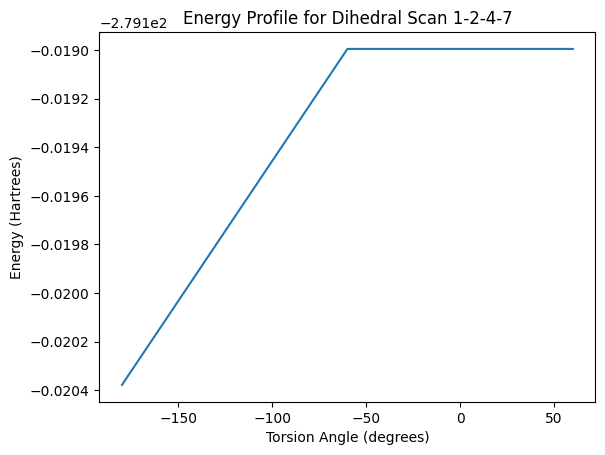

In [15]:
plt.plot(energy_for_angle.keys(), energy_for_angle.values())
plt.xlabel("Torsion Angle (degrees)")
plt.ylabel("Energy (Hartrees)")
plt.title(f"Energy Profile for Dihedral Scan {f4_data['dihedral_labels'][0]}")

In [17]:
# adjust the frame rate to your liking
FRAME_ANIMATION_TIME = 0.01

optimization_viewer = py3Dmol.view(width=800, height=600)
optimization_viewer.show()
for frame in xyz_for_angle.values():
    optimization_viewer.removeAllModels()
    optimization_viewer.addModel(frame, "xyz")
    optimization_viewer.setStyle({"stick": {}})
    optimization_viewer.zoomTo()
    optimization_viewer.render()
    IPython.display.clear_output(wait=True)
    IPython.display.display(optimization_viewer.show())
    time.sleep(FRAME_ANIMATION_TIME)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

# 4) SMIRNOFF Force Field Fitting

With the generated data, we now wish to fit a custom SMIRNOFF force field.

## 4.1) SMIRNOFF FF fitting parameters

In [18]:
help(client.smirnoff_ff_fitting)

Help on function smirnoff_ff_fitting in module rush.provider:

smirnoff_ff_fitting(*args: typing_extensions.Unpack[tuple[RushObject[Record], RushObject[NoneType]]], target: 'Target | None' = None, resources: 'Resources | None' = None, tags: 'list[str] | None' = None, restore: 'bool | None' = None) -> tuple[RushObject[NoneType]]
    fit a smirnoff force field
    
    Module version:  
    `github:talo/SMIRNOFF_FF_fitting/92ecb35610f72de67a57760425e52d0f1ba7ef9e#smirnoff_ff_fitting_tengu`
    
    QDX Type Description:
    
        in: Object {
            format: ObjectFormat[json | bin]?,
            path: @F4DataGenerationResult {
                dihedral_data: [[TorsionAngleEntry {
                    connectivity: [[f64]],
                    energy: f64,
                    optimised_geometry: OptimizedGeometry {
                        global_indices: [u32],
                        symbols: [string],
                        coords: [[f64]]
                    },
                 

## 4.2) Prepare SMIRNOFF Inputs

In [19]:
unfitted_ff_data = """
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
	<Bonds version="0.3" potential="harmonic" fractional_bondorder_method="None" fractional_bondorder_interpolation="linear">
		<Bond smirks="[#6X4:1]-[#6X4:2]" length="1.526 * angstrom" k="620.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b1" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#6X3:2]" length="1.51 * angstrom" k="634.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b2" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#6X3:2]=[#8X1+0]" length="1.522 * angstrom" k="634.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b3" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#6X3:2]" length="1.45 * angstrom" k="820.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b4" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]:[#6X3:2]" length="1.4 * angstrom" k="938.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b5" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]=[#6X3:2]" length="1.35 * angstrom" k="1098.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b6" parameterize="k,length"/>
		<Bond smirks="[#6:1]-[#7:2]" length="1.47 * angstrom" k="734.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b7" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#7X3:2]" length="1.38 * angstrom" k="854.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b8" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#7X3:2]-[#6X3]=[#8X1+0]" length="1.449 * angstrom" k="674.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b9" parameterize="k,length"/>
		<Bond smirks="[#6X3:1](=[#8X1+0])-[#7X3:2]" length="1.335 * angstrom" k="980.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b10" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#7X2:2]" length="1.39 * angstrom" k="820.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b11" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]:[#7X2,#7X3+1:2]" length="1.34 * angstrom" k="960.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b12" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]=[#7X2,#7X3+1:2]" length="1.3 * angstrom" k="1060.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b13" parameterize="k,length"/>
		<Bond smirks="[#6:1]-[#8:2]" length="1.41 * angstrom" k="640.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b14" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#8X2H0:2]" length="1.37 * angstrom" k="640.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b15" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#8X2:2]" length="1.326 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b16" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#8X2H1:2]" length="1.364 * angstrom" k="900.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b17" parameterize="k,length"/>
		<Bond smirks="[#6X3a:1]-[#8X2H0:2]" length="1.323 * angstrom" k="900.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b18" parameterize="k,length"/>
		<Bond smirks="[#6X3:1](=[#8X1])-[#8X2H0:2]" length="1.34 * angstrom" k="640.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b19" parameterize="k,length"/>
		<Bond smirks="[#6:1]=[#8X1+0,#8X2+1:2]" length="1.229 * angstrom" k="1140.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b20" parameterize="k,length"/>
		<Bond smirks="[#6X3:1](~[#8X1])~[#8X1:2]" length="1.25 * angstrom" k="1312.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b21" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]~[#8X2+1:2]~[#6X3]" length="1.28 * angstrom" k="1140.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b22" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]-[#6:2]" length="1.44 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b23" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]-[#6X4:2]" length="1.468 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b24" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]=[#6X3:2]" length="1.35 * angstrom" k="1098.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b25" parameterize="k,length"/>
		<Bond smirks="[#6:1]#[#7:2]" length="1.188 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b26" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]#[#6X2:2]" length="1.188 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b27" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]-[#8X2:2]" length="1.326 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b28" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]-[#7:2]" length="1.38 * angstrom" k="854.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b29" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]=[#7:2]" length="1.17 * angstrom" k="854.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b30" parameterize="k,length"/>
		<Bond smirks="[#16:1]=[#6:2]" length="1.7 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b31a" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]=[#16:2]" length="1.54 * angstrom" k="854.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b31" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#7:2]" length="1.4 * angstrom" k="760.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b32" parameterize="k,length"/>
		<Bond smirks="[#7X3:1]-[#7X2:2]" length="1.33 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b33" parameterize="k,length"/>
		<Bond smirks="[#7X2:1]-[#7X2:2]" length="1.33 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b34" parameterize="k,length"/>
		<Bond smirks="[#7:1]:[#7:2]" length="1.33 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b35" parameterize="k,length"/>
		<Bond smirks="[#7:1]=[#7:2]" length="1.3 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b36" parameterize="k,length"/>
		<Bond smirks="[#7:1]#[#7:2]" length="1.27 * angstrom" k="760.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b37" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#8X2:2]" length="1.4 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b38" parameterize="k,length"/>
		<Bond smirks="[#7:1]~[#8X1:2]" length="1.3 * angstrom" k="700.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b39" parameterize="k,length"/>
		<Bond smirks="[#8X2:1]-[#8X2:2]" length="1.46 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b40" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#6:2]" length="1.81 * angstrom" k="474.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b41" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#1:2]" length="1.336 * angstrom" k="548.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b42" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#16:2]" length="2.038 * angstrom" k="332.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b43" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#9:2]" length="1.6 * angstrom" k="750.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b44" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#17:2]" length="2.0 * angstrom" k="460.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b45" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#35:2]" length="2.2 * angstrom" k="340.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b46" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#53:2]" length="2.6 * angstrom" k="150.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b47" parameterize="k,length"/>
		<Bond smirks="[#16X2,#16X1-1,#16X3+1:1]-[#6X4:2]" length="1.81 * angstrom" k="474.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b48" parameterize="k,length"/>
		<Bond smirks="[#16X2,#16X1-1,#16X3+1:1]-[#6X3:2]" length="1.74 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b49" parameterize="k,length"/>
		<Bond smirks="[#16X2:1]-[#7:2]" length="1.69 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b50" parameterize="k,length"/>
		<Bond smirks="[#16X2:1]-[#8X2:2]" length="1.6 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b51" parameterize="k,length"/>
		<Bond smirks="[#16X2:1]=[#8X1,#7X2:2]" length="1.44 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b52" parameterize="k,length"/>
		<Bond smirks="[#16X4,#16X3!+1:1]-[#6:2]" length="1.75 * angstrom" k="454.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b53" parameterize="k,length"/>
		<Bond smirks="[#16X4,#16X3:1]~[#7:2]" length="1.71 * angstrom" k="530.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b54" parameterize="k,length"/>
		<Bond smirks="[#16X4,#16X3:1]-[#8X2:2]" length="1.596 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b55" parameterize="k,length"/>
		<Bond smirks="[#16X4,#16X3:1]~[#8X1:2]" length="1.44 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b56" parameterize="k,length"/>
		<Bond smirks="[#15:1]-[#1:2]" length="1.4 * angstrom" k="400.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b58" parameterize="k,length"/>
		<Bond smirks="[#15:1]~[#6:2]" length="1.9 * angstrom" k="320.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b59" parameterize="k,length"/>
		<Bond smirks="[#15:1]-[#7:2]" length="1.65 * angstrom" k="600.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b60" parameterize="k,length"/>
		<Bond smirks="[#15:1]=[#7:2]" length="1.5 * angstrom" k="800.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b61" parameterize="k,length"/>
		<Bond smirks="[#15:1]~[#8X2:2]" length="1.61 * angstrom" k="460.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b62" parameterize="k,length"/>
		<Bond smirks="[#15:1]~[#8X1:2]" length="1.48 * angstrom" k="1050.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b63" parameterize="k,length"/>
		<Bond smirks="[#16:1]-[#15:2]" length="2.1 * angstrom" k="300.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b65" parameterize="k,length"/>
		<Bond smirks="[#15:1]=[#16X1:2]" length="1.98 * angstrom" k="460.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b66" parameterize="k,length"/>
		<Bond smirks="[#6:1]-[#9:2]" length="1.359 * angstrom" k="772.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b67" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#9:2]" length="1.38 * angstrom" k="734.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b68" parameterize="k,length"/>
		<Bond smirks="[#6:1]-[#17:2]" length="1.727 * angstrom" k="386.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b69" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#17:2]" length="1.766 * angstrom" k="464.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b70" parameterize="k,length"/>
		<Bond smirks="[#6:1]-[#35:2]" length="1.89 * angstrom" k="344.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b71" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#35:2]" length="1.944 * angstrom" k="318.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b72" parameterize="k,length"/>
		<Bond smirks="[#6:1]-[#53:2]" length="2.075 * angstrom" k="342.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b73" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#53:2]" length="2.166 * angstrom" k="296.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b74" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#9:2]" length="1.4 * angstrom" k="340.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b75" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#17:2]" length="1.8 * angstrom" k="300.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b76" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#35:2]" length="2.0 * angstrom" k="220.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b77" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#53:2]" length="2.1 * angstrom" k="160.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b78" parameterize="k,length"/>
		<Bond smirks="[#15:1]-[#9:2]" length="1.64 * angstrom" k="880.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b79" parameterize="k,length"/>
		<Bond smirks="[#15:1]-[#17:2]" length="2.0 * angstrom" k="340.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b80" parameterize="k,length"/>
		<Bond smirks="[#15:1]-[#35:2]" length="2.2 * angstrom" k="270.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b81" parameterize="k,length"/>
		<Bond smirks="[#15:1]-[#53:2]" length="2.6 * angstrom" k="140.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b82" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#1:2]" length="1.09 * angstrom" k="680.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b83" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#1:2]" length="1.08 * angstrom" k="734.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b84" parameterize="k,length"/>
		<Bond smirks="[#6X2:1]-[#1:2]" length="1.056 * angstrom" k="800.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b85" parameterize="k,length"/>
		<Bond smirks="[#7:1]-[#1:2]" length="1.01 * angstrom" k="868.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b86" parameterize="k,length"/>
		<Bond smirks="[#8:1]-[#1:2]" length="0.96 * angstrom" k="1106.0 * angstrom**-2 * mole**-1 * kilocalorie" id="b87" parameterize="k,length"/>
	</Bonds>
	<Angles version="0.3" potential="harmonic">
		<Angle smirks="[*:1]~[#6X4:2]-[*:3]" angle="109.5 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a1" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[#6X4:2]-[#1:3]" angle="109.5 * degree" k="70.0 * mole**-1 * radian**-2 * kilocalorie" id="a2" parameterize="k,angle"/>
		<Angle smirks="[*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1" angle="60.0 * degree" k="700.0 * mole**-1 * radian**-2 * kilocalorie" id="a3" parameterize="k,angle"/>
		<Angle smirks="[*;r3:1]~;@[*;r3:2]~;!@[*:3]" angle="118.0 * degree" k="200.0 * mole**-1 * radian**-2 * kilocalorie" id="a4" parameterize="k,angle"/>
		<Angle smirks="[*:1]~;!@[*;r3:2]~;!@[*:3]" angle="113.0 * degree" k="200.0 * mole**-1 * radian**-2 * kilocalorie" id="a5" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[*;r3:2]~;!@[*:3]" angle="113.0 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a6" parameterize="k,angle"/>
		<Angle smirks="[#6r4:1]-;@[#6r4:2]-;@[#6r4:3]" angle="88.0 * degree" k="144.0 * mole**-1 * radian**-2 * kilocalorie" id="a7" parameterize="k,angle"/>
		<Angle smirks="[!#1:1]-[#6r4:2]-;!@[!#1:3]" angle="119.0 * degree" k="126.0 * mole**-1 * radian**-2 * kilocalorie" id="a8" parameterize="k,angle"/>
		<Angle smirks="[!#1:1]-[#6r4:2]-;!@[#1:3]" angle="115.0 * degree" k="90.0 * mole**-1 * radian**-2 * kilocalorie" id="a9" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#6X3:2]~[*:3]" angle="120.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a10" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[#6X3:2]~[*:3]" angle="120.0 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a11" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[#6X3:2]-[#1:3]" angle="120.0 * degree" k="70.0 * mole**-1 * radian**-2 * kilocalorie" id="a12" parameterize="k,angle"/>
		<Angle smirks="[*;r6:1]~;@[*;r5:2]~;@[*;r5;x2:3]" angle="130.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a13" parameterize="k,angle"/>
		<Angle smirks="[*:1]~;!@[*;X3;r5:2]~;@[*;r5:3]" angle="125.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a14" parameterize="k,angle"/>
		<Angle smirks="[#8X1:1]~[#6X3:2]~[#8:3]" angle="126.0 * degree" k="160.0 * mole**-1 * radian**-2 * kilocalorie" id="a15" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#6X2:2]~[*:3]" angle="180.0 * degree" k="160.0 * mole**-1 * radian**-2 * kilocalorie" id="a16" parameterize="k,angle"/>
		<Angle smirks="[*:1]-[#7X4,#7X3,#7X2-1:2]-[*:3]" angle="109.5 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a17" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[#7X4,#7X3,#7X2-1:2]-[*:3]" angle="109.5 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a18" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]~[*:3]" angle="120.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a19" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]-[*:3]" angle="120.0 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a20" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#7X2:2]~[*:3]" angle="180.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a21" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#7X2+0:2]~[*:3]" angle="120.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a22" parameterize="k,angle"/>
		<Angle smirks="[#1:1]-[#7X2+0:2]~[*:3]" angle="120.0 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a23" parameterize="k,angle"/>
		<Angle smirks="[#6,#7,#8:1]-[#7X3:2](~[#8X1])~[#8X1:3]" angle="117.7 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a24" parameterize="k,angle"/>
		<Angle smirks="[#8X1:1]~[#7X3:2]~[#8X1:3]" angle="124.5 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a25" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#7X2:2]~[#7X1:3]" angle="180.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a26" parameterize="k,angle"/>
		<Angle smirks="[*:1]-[#8:2]-[*:3]" angle="113.0 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a27" parameterize="k,angle"/>
		<Angle smirks="[#6X3,#7:1]~;@[#8;r:2]~;@[#6X3,#7:3]" angle="120.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a28" parameterize="k,angle"/>
		<Angle smirks="[*:1]-[#8X2+1:2]=[*:3]" angle="120.0 * degree" k="100.0 * mole**-1 * radian**-2 * kilocalorie" id="a29" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#16X4:2]~[*:3]" angle="109.5 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a30" parameterize="k,angle"/>
		<Angle smirks="[*:1]-[#16X4,#16X3+0:2]-[*:3]" angle="109.5 * degree" k="120.0 * mole**-1 * radian**-2 * kilocalorie" id="a31" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#16X3$(*~[#8X1,#7X2]):2]~[*:3]" angle="109.5 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a32" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#16X2,#16X3+1:2]~[*:3]" angle="98.0 * degree" k="120.0 * mole**-1 * radian**-2 * kilocalorie" id="a33" parameterize="k,angle"/>
		<Angle smirks="[*:1]=[#16X2:2]=[*:3]" angle="180.0 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a34" parameterize="k,angle"/>
		<Angle smirks="[#6X3:1]-[#16X2:2]-[#6X3:3]" angle="95.0 * degree" k="120.0 * mole**-1 * radian**-2 * kilocalorie" id="a35" parameterize="k,angle"/>
		<Angle smirks="[#6X3:1]-[#16X2:2]-[#6X4:3]" angle="100.0 * degree" k="120.0 * mole**-1 * radian**-2 * kilocalorie" id="a36" parameterize="k,angle"/>
		<Angle smirks="[#6X3:1]-[#16X2:2]-[#1:3]" angle="96.0 * degree" k="86.0 * mole**-1 * radian**-2 * kilocalorie" id="a37" parameterize="k,angle"/>
		<Angle smirks="[*:1]~[#15:2]~[*:3]" angle="109.5 * degree" k="140.0 * mole**-1 * radian**-2 * kilocalorie" id="a38" parameterize="k,angle"/>
	</Angles>
	<ProperTorsions version="0.3" potential="k*(1+cos(periodicity*theta-phase))" default_idivf="auto">
		<Proper smirks="[*:1]-[#6X4:2]-[#6X4:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.156 * mole**-1 * kilocalorie" id="t1" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#6X4:3]-[#6X4:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="180.0 * degree" phase3="180.0 * degree" k1="0.18 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" k3="0.2 * mole**-1 * kilocalorie" id="t2" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X4:3]-[#1:4]" periodicity1="3" phase1="0.0 * degree" k1="0.15 * mole**-1 * kilocalorie" id="t3" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X4:3]-[#6X4:4]" periodicity1="3" phase1="0.0 * degree" k1="0.16 * mole**-1 * kilocalorie" id="t4" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#8X2:1]-[#6X4:2]-[#6X4:3]-[#8X2:4]" periodicity1="3" periodicity2="2" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.144 * mole**-1 * kilocalorie" k2="1.175 * mole**-1 * kilocalorie" id="t5" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#9:1]-[#6X4:2]-[#6X4:3]-[#9:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="1.2 * mole**-1 * kilocalorie" id="t6" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#17:1]-[#6X4:2]-[#6X4:3]-[#17:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.45 * mole**-1 * kilocalorie" id="t7" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#35:1]-[#6X4:2]-[#6X4:3]-[#35:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.0 * mole**-1 * kilocalorie" id="t8" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X4:3]-[#8X2:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" id="t9" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X4:3]-[#9:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.19 * mole**-1 * kilocalorie" id="t10" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X4:3]-[#17:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" id="t11" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X4:3]-[#35:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.55 * mole**-1 * kilocalorie" id="t12" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#6X4;r3:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t13" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#6X4;r3:3]-[#6X4;r3:4]" periodicity1="3" phase1="0.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="t14" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4;r3:2]-@[#6X4;r3:3]-[*:4]" periodicity1="2" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t15" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4;r3:1]-[#6X4;r3:2]-[#6X4;r3:3]-[*:4]" periodicity1="2" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="3.0 * mole**-1 * kilocalorie" k2="2.7 * mole**-1 * kilocalorie" id="t16" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]~[#6X3:2]-[#6X4:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t17" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#6X3:3]=[*:4]" periodicity1="2" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t20" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X3:3]=[#8X1:4]" periodicity1="1" periodicity2="2" periodicity3="3" phase1="0.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" k1="0.8 * mole**-1 * kilocalorie" k2="0.0 * mole**-1 * kilocalorie" k3="0.08 * mole**-1 * kilocalorie" id="t18" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#1:1]-[#6X4:2]-[#6X3:3]=[#6X3:4]" periodicity1="3" periodicity2="1" periodicity3="3" phase1="180.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" k1="0.38 * mole**-1 * kilocalorie" k2="1.15 * mole**-1 * kilocalorie" k3="1.0 * mole**-1 * kilocalorie" id="t19" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X3:1]-[#6X4:2]-[#6X3:3]=[#6X3:4]" periodicity1="3" periodicity2="2" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.45 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" id="t21" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#7X3:1]-[#6X4:2]-[#6X3:3]-[#7X3:4]" periodicity1="1" periodicity2="2" phase1="180.0 * degree" phase2="180.0 * degree" k1="1.7 * mole**-1 * kilocalorie" k2="2.0 * mole**-1 * kilocalorie" id="t22" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#6X3:3]-[#7X3:4]" periodicity1="4" periodicity2="2" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.1 * mole**-1 * kilocalorie" k2="0.07 * mole**-1 * kilocalorie" id="t23" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#16X2,#16X1-1,#16X3+1:1]-[#6X3:2]-[#6X4:3]-[#1:4]" periodicity1="2" periodicity2="1" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.26 * mole**-1 * kilocalorie" k2="0.35 * mole**-1 * kilocalorie" id="t24" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#16X2,#16X1-1,#16X3+1:1]-[#6X3:2]-[#6X4:3]-[#7X4,#7X3:4]" periodicity1="4" periodicity2="3" periodicity3="2" periodicity4="2" periodicity5="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" phase4="270.0 * degree" phase5="90.0 * degree" k1="0.988 * mole**-1 * kilocalorie" k2="0.258 * mole**-1 * kilocalorie" k3="0.805 * mole**-1 * kilocalorie" k4="2.059 * mole**-1 * kilocalorie" k5="1.71 * mole**-1 * kilocalorie" id="t25" idivf1="1.0" idivf2="1.0" idivf3="1.0" idivf4="1.0" idivf5="1.0" parameterize="k1,k2,k3,k4,k5"/>
		<Proper smirks="[#16X2,#16X1-1,#16X3+1:1]-[#6X3:2]-[#6X4:3]-[#7X3$(*-[#6X3,#6X2]):4]" periodicity1="4" periodicity2="3" periodicity3="2" periodicity4="2" periodicity5="1" periodicity6="1" phase1="270.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" phase4="270.0 * degree" phase5="270.0 * degree" phase6="0.0 * degree" k1="0.285 * mole**-1 * kilocalorie" k2="0.669 * mole**-1 * kilocalorie" k3="0.31 * mole**-1 * kilocalorie" k4="0.548 * mole**-1 * kilocalorie" k5="0.263 * mole**-1 * kilocalorie" k6="0.222 * mole**-1 * kilocalorie" id="t26" idivf1="1.0" idivf2="1.0" idivf3="1.0" idivf4="1.0" idivf5="1.0" idivf6="1.0" parameterize="k1,k2,k3,k4,k5,k6"/>
		<Proper smirks="[*:1]-[#6X4;r3:2]-[#6X3:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t27" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#6X4;r3:2]-[#6X3:3]~[#6X3:4]" periodicity1="4" periodicity2="2" phase1="180.0 * degree" phase2="180.0 * degree" k1="0.065 * mole**-1 * kilocalorie" k2="0.55 * mole**-1 * kilocalorie" id="t28" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#1:1]-[#6X4;r3:2]-[#6X3:3]~[#6X3:4]" periodicity1="4" periodicity2="3" periodicity3="2" phase1="180.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" k1="0.05 * mole**-1 * kilocalorie" k2="0.15 * mole**-1 * kilocalorie" k3="0.15 * mole**-1 * kilocalorie" id="t29" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X3:1]-[#6X4;r3:2]-[#6X3:3]-[#7X3:4]" periodicity1="2" periodicity2="1" periodicity3="3" phase1="0.0 * degree" phase2="180.0 * degree" phase3="180.0 * degree" k1="1.392 * mole**-1 * kilocalorie" k2="0.645 * mole**-1 * kilocalorie" k3="0.961 * mole**-1 * kilocalorie" id="t30" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X3:1]-[#6X4;r3:2]-[#6X3:3]=[#8X1:4]" periodicity1="2" periodicity2="1" periodicity3="3" phase1="180.0 * degree" phase2="180.0 * degree" phase3="180.0 * degree" k1="3.174 * mole**-1 * kilocalorie" k2="0.277 * mole**-1 * kilocalorie" k3="0.514 * mole**-1 * kilocalorie" id="t31" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X3:1]-[#6X4;r3:2]-[#6X3:3]~[#6X3:4]" periodicity1="2" phase1="180.0 * degree" k1="0.128 * mole**-1 * kilocalorie" id="t32" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#7X3:1]-[#6X4;r3:2]-[#6X3:3]~[#6X3:4]" periodicity1="4" periodicity2="2" phase1="180.0 * degree" phase2="180.0 * degree" k1="0.065 * mole**-1 * kilocalorie" k2="0.55 * mole**-1 * kilocalorie" id="t33" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]~[#6X3:4]" periodicity1="4" periodicity2="3" periodicity3="2" phase1="180.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" k1="0.05 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" k3="0.01 * mole**-1 * kilocalorie" id="t34" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3;r6:3]:[#6X3;r6:4]" periodicity1="4" periodicity2="2" phase1="180.0 * degree" phase2="180.0 * degree" k1="0.065 * mole**-1 * kilocalorie" k2="0.55 * mole**-1 * kilocalorie" id="t35" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3;r5:3]-;@[#6X3;r5:4]" periodicity1="4" periodicity2="3" periodicity3="2" phase1="180.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" k1="0.05 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" k3="0.01 * mole**-1 * kilocalorie" id="t36" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3;r5:3]=;@[#6X3;r5:4]" periodicity1="1" phase1="180.0 * degree" k1="0.3 * mole**-1 * kilocalorie" id="t37" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]-[#6X4:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t38" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3;r6:3]:[#7X2;r6:4]" periodicity1="2" periodicity2="1" periodicity3="3" phase1="180.0 * degree" phase2="180.0 * degree" phase3="0.0 * degree" k1="2.1 * mole**-1 * kilocalorie" k2="0.432 * mole**-1 * kilocalorie" k3="0.62 * mole**-1 * kilocalorie" id="t39" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]=[#7X2:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="180.0 * degree" phase3="180.0 * degree" k1="0.3 * mole**-1 * kilocalorie" k2="0.95 * mole**-1 * kilocalorie" k3="0.275 * mole**-1 * kilocalorie" id="t40" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]-[#8X2:4]" periodicity1="4" periodicity2="2" phase1="180.0 * degree" phase2="180.0 * degree" k1="0.065 * mole**-1 * kilocalorie" k2="0.55 * mole**-1 * kilocalorie" id="t41" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]=[#8X1:4]" periodicity1="2" phase1="320.0 * degree" k1="2.4 * mole**-1 * kilocalorie" id="t42" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#6X3:2]-[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.625 * mole**-1 * kilocalorie" id="t43" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#6X3:2]:[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="3.625 * mole**-1 * kilocalorie" id="t44" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-,:[#6X3:2]=[#6X3:3]-,:[*:4]" periodicity1="2" phase1="180.0 * degree" k1="5.4 * mole**-1 * kilocalorie" id="t45" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#6X3:2]=[#6X3:3]-[#6X4:4]" periodicity1="2" periodicity2="1" phase1="180.0 * degree" phase2="180.0 * degree" k1="6.65 * mole**-1 * kilocalorie" k2="1.9 * mole**-1 * kilocalorie" id="t46" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]~[#6X3:2]-[#6X3$(*=[#8,#16,#7]):3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.25 * mole**-1 * kilocalorie" id="t47" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]=[#6X3:2]-[#6X3:3]=[#8X1:4]" periodicity1="2" periodicity2="3" phase1="180.0 * degree" phase2="0.0 * degree" k1="2.175 * mole**-1 * kilocalorie" k2="0.3 * mole**-1 * kilocalorie" id="t48" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]~[#7a:2]:[#6a:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="4.8 * mole**-1 * kilocalorie" id="t49" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#7X4:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.156 * mole**-1 * kilocalorie" id="t50" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#7X3:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.3 * mole**-1 * kilocalorie" id="t51" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#7X4,#7X3:3]-[#6X4:4]" periodicity1="3" periodicity2="2" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.3 * mole**-1 * kilocalorie" k2="0.48 * mole**-1 * kilocalorie" id="t52" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#1:1]-[#7X4,#7X3:2]-[#6X4;r3:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t54" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#7X4,#7X3:2]-[#6X4;r3:3]-[#6X4;r3:4]" periodicity1="1" phase1="0.0 * degree" k1="2.7 * mole**-1 * kilocalorie" id="t55" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[!#1:1]-[#7X4,#7X3:2]-[#6X4;r3:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.156 * mole**-1 * kilocalorie" id="t56" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[!#1:1]-[#7X4,#7X3:2]-[#6X4;r3:3]-[#6X4;r3:4]" periodicity1="3" phase1="0.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="t57" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#7X4:2]-[#6X3:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t58" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#7X3$(*~[#6X3,#6X2]):3]~[*:4]" periodicity1="2" periodicity2="3" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="0.0 * mole**-1 * kilocalorie" id="t59" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#7X3$(*~[#8X1]):3]~[#8X1:4]" periodicity1="3" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t60" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]-[#7X3:2]-[#6X4:3]-[#6X3:4]" periodicity1="2" periodicity2="1" phase1="180.0 * degree" phase2="0.0 * degree" k1="0.85 * mole**-1 * kilocalorie" k2="0.8 * mole**-1 * kilocalorie" id="t61" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#7X3:3]-[#6X3:4]=[#8,#16,#7]" periodicity1="4" periodicity2="3" periodicity3="2" periodicity4="1" phase1="180.0 * degree" phase2="180.0 * degree" phase3="0.0 * degree" phase4="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" k2="0.15 * mole**-1 * kilocalorie" k3="0.0 * mole**-1 * kilocalorie" k4="0.53 * mole**-1 * kilocalorie" id="t62" idivf1="1.0" idivf2="1.0" idivf3="1.0" idivf4="1.0" parameterize="k1,k2,k3,k4"/>
		<Proper smirks="[#8X2H0:1]-[#6X4:2]-[#7X3:3]-[#6X3:4]" periodicity1="2" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" k2="2.5 * mole**-1 * kilocalorie" id="t63" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X3:1]-[#7X3:2]-[#6X4;r3:3]-[#6X4;r3:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" k2="1.75 * mole**-1 * kilocalorie" k3="0.25 * mole**-1 * kilocalorie" id="t64" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[*:1]~[#7X2:2]-[#6X4:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t65" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]=[#7X2,#7X3+1:2]-[#6X4:3]-[#1:4]" periodicity1="1" phase1="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" id="t66" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]=[#7X2,#7X3+1:2]-[#6X4:3]-[#6X3,#6X4:4]" periodicity1="1" phase1="0.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="t67" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#7X3,#7X2-1:2]-[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="t68" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#7X3,#7X2-1:2]-!@[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.625 * mole**-1 * kilocalorie" id="t69" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#7X3:2]-[#6X3:3]=[#8,#16,#7:4]" periodicity1="2" periodicity2="1" phase1="180.0 * degree" phase2="0.0 * degree" k1="2.5 * mole**-1 * kilocalorie" k2="2.0 * mole**-1 * kilocalorie" id="t70" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]-[#7X3;r5:2]-@[#6X3;r5:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.4 * mole**-1 * kilocalorie" id="t71" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#8X1:1]~[#7X3:2]~[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="3.6 * mole**-1 * kilocalorie" id="t72" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]=[#7X2,#7X3+1:2]-[#6X3:3]-[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t73" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]=[#7X2,#7X3+1:2]-[#6X3:3]=,:[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.5 * mole**-1 * kilocalorie" id="t74" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#7X2,#7X3$(*~[#8X1]):2]:[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="3.0 * mole**-1 * kilocalorie" id="t75" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]:[#7X2:2]:[#6X3:3]:[#6X3:4]" periodicity1="2" phase1="180.0 * degree" k1="4.8 * mole**-1 * kilocalorie" id="t76" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-,:[#6X3:2]=[#7X2:3]-[*:4]" periodicity1="2" phase1="180.0 * degree" k1="5.0 * mole**-1 * kilocalorie" id="t77" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#7X3+1:2]=,:[#6X3:3]-,:[*:4]" periodicity1="2" phase1="180.0 * degree" k1="2.4 * mole**-1 * kilocalorie" id="t78" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#16X4,#16X3+0:1]-[#7X2:2]=[#6X3:3]-[#7X3:4]" periodicity1="2" phase1="180.0 * degree" k1="7.5 * mole**-1 * kilocalorie" id="t79" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#16X4,#16X3+0:1]-[#7X2:2]=[#6X3:3]-[#16X2,#16X3+1:4]" periodicity1="2" phase1="180.0 * degree" k1="7.5 * mole**-1 * kilocalorie" id="t80" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#7X2:1]~[#7X2:2]-[#6X3:3]~[#6X3:4]" periodicity1="2" phase1="180.0 * degree" k1="0.5 * mole**-1 * kilocalorie" id="t81" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#7X2:1]~[#7X2:2]-[#6X4:3]-[#6X3:4]" periodicity1="2" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t82" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#7X2:1]~[#7X2:2]-[#6X4:3]~[#1:4]" periodicity1="2" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t83" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#8X2:3]-[#1:4]" periodicity1="3" phase1="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" id="t84" idivf1="3.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#8X2H1:3]-[#1:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.16 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" id="t85" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]-[#6X4:2]-[#8X2H0:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="1.15 * mole**-1 * kilocalorie" id="t86" idivf1="3.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#8X2H0:3]-[#6X4:4]" periodicity1="3" periodicity2="2" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.383 * mole**-1 * kilocalorie" k2="0.1 * mole**-1 * kilocalorie" id="t87" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4:1]-[#6X4:2]-[#8X2:3]-[#6X3:4]" periodicity1="3" periodicity2="1" phase1="0.0 * degree" phase2="180.0 * degree" k1="0.383 * mole**-1 * kilocalorie" k2="0.8 * mole**-1 * kilocalorie" id="t88" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X4:1]-[#8X2:2]-[#6X4:3]-[#8X2:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="180.0 * degree" phase3="180.0 * degree" k1="0.1 * mole**-1 * kilocalorie" k2="0.85 * mole**-1 * kilocalorie" k3="1.35 * mole**-1 * kilocalorie" id="t89" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4:1]-[#8X2:2]-[#6X4:3]-[#7X3:4]" periodicity1="3" periodicity2="2" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.383 * mole**-1 * kilocalorie" k2="0.65 * mole**-1 * kilocalorie" id="t90" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X3:1]-[#8X2:2]-[#6X4;r3:3]-@[#6X4;r3:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t91" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]-[#8X2:2]-[#6X4;r3:3]-[#1:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t92" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#8X2:2]-[#6X4;r3:3]-[#1:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.4 * mole**-1 * kilocalorie" k2="0.5 * mole**-1 * kilocalorie" k3="0.7 * mole**-1 * kilocalorie" id="t93" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#1:1]-[#8X2:2]-[#6X4;r3:3]-[#6X4:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.4 * mole**-1 * kilocalorie" k2="0.5 * mole**-1 * kilocalorie" k3="0.7 * mole**-1 * kilocalorie" id="t94" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#1:1]-[#8X2:2]-[#6X4;r3:3]-[#6X4;r3:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.4 * mole**-1 * kilocalorie" k2="0.5 * mole**-1 * kilocalorie" k3="0.7 * mole**-1 * kilocalorie" id="t95" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[*:1]~[#6X3:2]-[#8X2:3]-[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.05 * mole**-1 * kilocalorie" id="t96" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#6X3:2]-[#8X2:3]-[#1:4]" periodicity1="2" phase1="180.0 * degree" k1="0.9 * mole**-1 * kilocalorie" id="t97" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#6X3:2](=[#8,#16,#7])-[#8X2H0:3]-[*:4]" periodicity1="2" phase1="180.0 * degree" k1="2.7 * mole**-1 * kilocalorie" id="t98" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#6X3:2](=[#8,#16,#7])-[#8:3]-[#1:4]" periodicity1="2" phase1="180.0 * degree" k1="2.3 * mole**-1 * kilocalorie" id="t99" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#8X2:2]-[#6X3:3]=[#8X1:4]" periodicity1="2" periodicity2="1" phase1="180.0 * degree" phase2="0.0 * degree" k1="2.3 * mole**-1 * kilocalorie" k2="1.9 * mole**-1 * kilocalorie" id="t100" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#8,#16,#7:1]=[#6X3:2]-[#8X2H0:3]-[#6X4:4]" periodicity1="2" periodicity2="1" phase1="180.0 * degree" phase2="180.0 * degree" k1="2.7 * mole**-1 * kilocalorie" k2="1.4 * mole**-1 * kilocalorie" id="t101" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]-[#8X2:2]@[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="2.5 * mole**-1 * kilocalorie" id="t102" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#8X2+1:2]=[#6X3:3]-[*:4]" periodicity1="2" phase1="180.0 * degree" k1="3.0 * mole**-1 * kilocalorie" id="t103" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]=[#8X2+1:2]-[#6:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.5 * mole**-1 * kilocalorie" id="t104" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#16:2]=,:[#6:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="6.5 * mole**-1 * kilocalorie" id="t105" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#16X2,#16X3+1:2]-[#6:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.333 * mole**-1 * kilocalorie" id="t106" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#16X2,#16X3+1:2]-[#6:3]-[#1:4]" periodicity1="3" phase1="0.0 * degree" k1="0.25 * mole**-1 * kilocalorie" id="t107" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]-@[#16X2,#16X1-1,#16X3+1:2]-@[#6X3,#7X2;r5:3]=@[#6,#7;r5:4]" periodicity1="2" phase1="180.0 * degree" k1="2.0 * mole**-1 * kilocalorie" id="t108" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#16X4,#16X3!+1:2]-[#6X4:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t109" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#16X4,#16X3+0:2]-[#6X4:3]-[#1:4]" periodicity1="1" phase1="0.0 * degree" k1="0.25 * mole**-1 * kilocalorie" id="t110" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#16X4,#16X3+0:2]-[#6X4:3]~[#6X4:4]" periodicity1="3" phase1="0.0 * degree" k1="0.8 * mole**-1 * kilocalorie" id="t111" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#16X4,#16X3+0:2]-[#6X3:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.75 * mole**-1 * kilocalorie" id="t112" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6:1]-[#16X4,#16X3+0:2]-[#6X3:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.75 * mole**-1 * kilocalorie" id="t113" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#15:2]-[#6:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t114" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#15:2]-[#6X3:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="t115" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#8:2]-[#8:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.4 * mole**-1 * kilocalorie" id="t116" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#8:2]-[#8H1:3]-[*:4]" periodicity1="2" phase1="0.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="t117" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#8X2:2]-[#7:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t118" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#8X2r5:2]-;@[#7X3r5:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t119" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#8X2r5:2]-;@[#7X2r5:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t120" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#7X4,#7X3:2]-[#7X4,#7X3:3]-[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t121" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#1:1]-[#7X4,#7X3:2]-[#7X4,#7X3:3]-[#1:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.125 * mole**-1 * kilocalorie" k2="1.875 * mole**-1 * kilocalorie" k3="0.75 * mole**-1 * kilocalorie" id="t122" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4:1]-[#7X4,#7X3:2]-[#7X4,#7X3:3]-[#1:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.4 * mole**-1 * kilocalorie" k2="2.15 * mole**-1 * kilocalorie" k3="1.2 * mole**-1 * kilocalorie" id="t123" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4:1]-[#7X4,#7X3:2]-[#7X4,#7X3:3]-[#6X4:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.375 * mole**-1 * kilocalorie" k2="2.125 * mole**-1 * kilocalorie" k3="1.5 * mole**-1 * kilocalorie" id="t124" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[*:1]-[#7X4,#7X3:2]-[#7X3$(*~[#6X3,#6X2]):3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t125" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#7X3$(*-[#6X3,#6X2]):2]-[#7X3$(*-[#6X3,#6X2]):3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t126" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#7X3$(*-[#6X3,#6X2])r5:2]-@[#7X3$(*-[#6X3,#6X2])r5:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="3.6 * mole**-1 * kilocalorie" id="t127" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]@[#7X2:2]@[#7X2:3]@[#7X2,#6X3:4]" periodicity1="1" phase1="180.0 * degree" k1="0.000 * mole**-1 * kilocalorie" id="t128a" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#7X2:2]-[#7X3:3]~[*:4]" periodicity1="1" phase1="180.0 * degree" k1="0.625 * mole**-1 * kilocalorie" id="t128" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]=[#7X2:2]-[#7X2:3]=[*:4]" periodicity1="1" phase1="180.0 * degree" k1="1.4 * mole**-1 * kilocalorie" id="t129" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#7X2:2]=,:[#7X2:3]~[*:4]" periodicity1="1" phase1="180.0 * degree" k1="6.0 * mole**-1 * kilocalorie" id="t130" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#7X3+1:2]=,:[#7X2:3]~[*:4]" periodicity1="1" phase1="180.0 * degree" k1="3.0 * mole**-1 * kilocalorie" id="t131" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#16X2,#16X3+1:2]-[!#6:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t133" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#16X4,#16X3+0:2]-[#7:3]~[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t134" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#16X4,#16X3+0:2]-[#7X4,#7X3:3]-[#1:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t135" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X3:1]-[#16X4,#16X3+0:2]-[#7X4,#7X3:3]-[#1:4]" periodicity1="3" phase1="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" id="t136" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#16X4,#16X3+0:2]-[#7X4,#7X3:3]-[#6X4:4]" periodicity1="1" periodicity2="3" phase1="0.0 * degree" phase2="0.0 * degree" k1="2.5 * mole**-1 * kilocalorie" k2="0.75 * mole**-1 * kilocalorie" id="t137" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X3:1]-[#16X4,#16X3+0:2]-[#7X4,#7X3:3]-[#6X4:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" k2="1.75 * mole**-1 * kilocalorie" k3="1.5 * mole**-1 * kilocalorie" id="t138" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#8X1:1]~[#16X4,#16X3+0:2]-[#7X4,#7X3:3]-[#1:4]" periodicity1="1" periodicity2="3" phase1="180.0 * degree" phase2="0.0 * degree" k1="1.0 * mole**-1 * kilocalorie" k2="0.25 * mole**-1 * kilocalorie" id="t139" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#8X1:1]~[#16X4,#16X3+0:2]-[#7X4,#7X3:3]-[#6X4:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="180.0 * degree" phase3="0.0 * degree" k1="0.2 * mole**-1 * kilocalorie" k2="0.3 * mole**-1 * kilocalorie" k3="0.7 * mole**-1 * kilocalorie" id="t140" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X3:1]-[#16X4,#16X3+0:2]-[#7X3:3]-[#6X3:4]" periodicity1="3" periodicity2="2" periodicity3="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" k2="1.75 * mole**-1 * kilocalorie" k3="1.5 * mole**-1 * kilocalorie" id="t141" idivf1="1.0" idivf2="1.0" idivf3="1.0" parameterize="k1,k2,k3"/>
		<Proper smirks="[#6X4:1]-[#16X4,#16X3+0:2]-[#7X3:3]-[#6X3:4]" periodicity1="3" periodicity2="2" phase1="90.0 * degree" phase2="0.0 * degree" k1="0.5 * mole**-1 * kilocalorie" k2="1.375 * mole**-1 * kilocalorie" id="t142" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#8X1:1]~[#16X4,#16X3+0:2]-[#7X3:3]-[#6X3:4]" periodicity1="1" phase1="0.0 * degree" k1="0.75 * mole**-1 * kilocalorie" id="t143" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#8X1:1]~[#16X4,#16X3+0:2]-[#7X3:3]-[#7X2:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t144" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[#16X4,#16X3+0:2]=,:[#7X2:3]-,:[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t145" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#6X4:1]-[#16X4,#16X3+0:2]-[#7X2:3]~[#6X3:4]" periodicity1="6" periodicity2="5" periodicity3="4" periodicity4="3" periodicity5="2" periodicity6="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="0.0 * degree" phase4="0.0 * degree" phase5="180.0 * degree" phase6="0.0 * degree" k1="0.04 * mole**-1 * kilocalorie" k2="0.407 * mole**-1 * kilocalorie" k3="0.013 * mole**-1 * kilocalorie" k4="0.018 * mole**-1 * kilocalorie" k5="1.329 * mole**-1 * kilocalorie" k6="0.927 * mole**-1 * kilocalorie" id="t146" idivf1="1.0" idivf2="1.0" idivf3="1.0" idivf4="1.0" idivf5="1.0" idivf6="1.0" parameterize="k1,k2,k3,k4,k5,k6"/>
		<Proper smirks="[#8X1:1]~[#16X4,#16X3+0:2]-[#7X2:3]~[#6X3:4]" periodicity1="6" periodicity2="5" periodicity3="4" periodicity4="2" periodicity5="3" periodicity6="1" phase1="0.0 * degree" phase2="0.0 * degree" phase3="180.0 * degree" phase4="180.0 * degree" phase5="180.0 * degree" phase6="0.0 * degree" k1="0.071 * mole**-1 * kilocalorie" k2="0.697 * mole**-1 * kilocalorie" k3="0.208 * mole**-1 * kilocalorie" k4="3.931 * mole**-1 * kilocalorie" k5="1.94 * mole**-1 * kilocalorie" k6="2.448 * mole**-1 * kilocalorie" id="t147" idivf1="1.0" idivf2="1.0" idivf3="1.0" idivf4="1.0" idivf5="1.0" idivf6="1.0" parameterize="k1,k2,k3,k4,k5,k6"/>
		<Proper smirks="[*:1]~[#16X4,#16X3+0:2]-[#8X2:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t148" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#16X2,#16X3+1:2]-[#16X2,#16X3+1:3]-[*:4]" periodicity1="2" periodicity2="3" phase1="0.0 * degree" phase2="0.0 * degree" k1="3.5 * mole**-1 * kilocalorie" k2="0.6 * mole**-1 * kilocalorie" id="t149" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]-[#8X2:2]-[#15:3]~[*:4]" periodicity1="3" phase1="0.0 * degree" k1="0.75 * mole**-1 * kilocalorie" id="t150" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[#8X2:1]-[#15:2]-[#8X2:3]-[#6X4:4]" periodicity1="3" periodicity2="2" phase1="0.0 * degree" phase2="0.0 * degree" k1="0.25 * mole**-1 * kilocalorie" k2="1.2 * mole**-1 * kilocalorie" id="t151" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[*:1]~[#7X3:2]-[#15:3]~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="2.5 * mole**-1 * kilocalorie" id="t152" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[#7:2]-[#15:3]=[*:4]" periodicity1="2" periodicity2="3" phase1="180.0 * degree" phase2="0.0 * degree" k1="3.0 * mole**-1 * kilocalorie" k2="2.3 * mole**-1 * kilocalorie" id="t154" idivf1="1.0" idivf2="1.0" parameterize="k1,k2"/>
		<Proper smirks="[#6X3:1]-[#7:2]-[#15:3]=[*:4]" periodicity1="1" phase1="0.0 * degree" k1="2.3 * mole**-1 * kilocalorie" id="t155" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]-[*:2]#[*:3]-[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t156" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[*:2]-[*:3]#[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t157" idivf1="1.0" parameterize="k1"/>
		<Proper smirks="[*:1]~[*:2]=[#6,#7,#16,#15;X2:3]=[*:4]" periodicity1="1" phase1="0.0 * degree" k1="0.0 * mole**-1 * kilocalorie" id="t158" idivf1="1.0" parameterize="k1"/>
	</ProperTorsions>
	<ImproperTorsions version="0.3" potential="k*(1+cos(periodicity*theta-phase))" default_idivf="auto">
		<Improper smirks="[*:1]~[#6X3:2](~[*:3])~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.1 * mole**-1 * kilocalorie" id="i1"/>
		<Improper smirks="[*:1]~[#6X3:2](~[#8X1:3])~[#8:4]" periodicity1="2" phase1="180.0 * degree" k1="10.5 * mole**-1 * kilocalorie" id="i2"/>
		<Improper smirks="[*:1]~[#7X3$(*~[#6X3]):2](~[*:3])~[*:4]" periodicity1="2" phase1="180.0 * degree" k1="1.0 * mole**-1 * kilocalorie" id="i3"/>
		<Improper smirks="[*:1]~[#6X3:2](=[#7X2,#7X3+1:3])~[#7:4]" periodicity1="2" phase1="180.0 * degree" k1="10.5 * mole**-1 * kilocalorie" id="i4"/>
	</ImproperTorsions>
	<vdW version="0.3" potential="Lennard-Jones-12-6" combining_rules="Lorentz-Berthelot" scale12="0.0" scale13="0.0" scale14="0.5" scale15="1.0" switch_width="1.0 * angstrom" cutoff="9.0 * angstrom" method="cutoff">
		<Atom smirks="[#1:1]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n1" rmin_half="0.6 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X4]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n2" rmin_half="1.487 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X4]-[#7,#8,#9,#16,#17,#35]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n3" rmin_half="1.387 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n4" rmin_half="1.287 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n5" rmin_half="1.187 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X4]~[*+1,*+2]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n6" rmin_half="1.1 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X3]" epsilon="0.015 * mole**-1 * kilocalorie" id="n7" rmin_half="1.459 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X3]~[#7,#8,#9,#16,#17,#35]" epsilon="0.015 * mole**-1 * kilocalorie" id="n8" rmin_half="1.409 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]" epsilon="0.015 * mole**-1 * kilocalorie" id="n9" rmin_half="1.359 * angstrom"/>
		<Atom smirks="[#1:1]-[#6X2]" epsilon="0.015 * mole**-1 * kilocalorie" id="n10" rmin_half="1.459 * angstrom"/>
		<Atom smirks="[#1:1]-[#7]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n11" rmin_half="0.6 * angstrom"/>
		<Atom smirks="[#1:1]-[#8]" epsilon="5.27e-05 * mole**-1 * kilocalorie" id="n12" rmin_half="0.3 * angstrom"/>
		<Atom smirks="[#1:1]-[#16]" epsilon="0.0157 * mole**-1 * kilocalorie" id="n13" rmin_half="0.6 * angstrom"/>
		<Atom smirks="[#6:1]" epsilon="0.086 * mole**-1 * kilocalorie" id="n14" rmin_half="1.908 * angstrom"/>
		<Atom smirks="[#6X2:1]" epsilon="0.21 * mole**-1 * kilocalorie" id="n15" rmin_half="1.908 * angstrom"/>
		<Atom smirks="[#6X4:1]" epsilon="0.1094 * mole**-1 * kilocalorie" id="n16" rmin_half="1.908 * angstrom"/>
		<Atom smirks="[#8:1]" epsilon="0.21 * mole**-1 * kilocalorie" id="n17" rmin_half="1.6612 * angstrom"/>
		<Atom smirks="[#8X2H0+0:1]" epsilon="0.17 * mole**-1 * kilocalorie" id="n18" rmin_half="1.6837 * angstrom"/>
		<Atom smirks="[#8X2H1+0:1]" epsilon="0.2104 * mole**-1 * kilocalorie" id="n19" rmin_half="1.721 * angstrom"/>
		<Atom smirks="[#7:1]" epsilon="0.17 * mole**-1 * kilocalorie" id="n20" rmin_half="1.824 * angstrom"/>
		<Atom smirks="[#16:1]" epsilon="0.25 * mole**-1 * kilocalorie" id="n21" rmin_half="2.0 * angstrom"/>
		<Atom smirks="[#15:1]" epsilon="0.2 * mole**-1 * kilocalorie" id="n22" rmin_half="2.1 * angstrom"/>
		<Atom smirks="[#9:1]" epsilon="0.061 * mole**-1 * kilocalorie" id="n23" rmin_half="1.75 * angstrom"/>
		<Atom smirks="[#17:1]" epsilon="0.265 * mole**-1 * kilocalorie" id="n24" rmin_half="1.948 * angstrom"/>
		<Atom smirks="[#35:1]" epsilon="0.32 * mole**-1 * kilocalorie" id="n25" rmin_half="2.22 * angstrom"/>
		<Atom smirks="[#53:1]" epsilon="0.4 * mole**-1 * kilocalorie" id="n26" rmin_half="2.35 * angstrom"/>
		<Atom smirks="[#3+1:1]" epsilon="0.0279896 * mole**-1 * kilocalorie" id="n27" rmin_half="1.025 * angstrom"/>
		<Atom smirks="[#11+1:1]" epsilon="0.0874393 * mole**-1 * kilocalorie" id="n28" rmin_half="1.369 * angstrom"/>
		<Atom smirks="[#19+1:1]" epsilon="0.1936829 * mole**-1 * kilocalorie" id="n29" rmin_half="1.705 * angstrom"/>
		<Atom smirks="[#37+1:1]" epsilon="0.3278219 * mole**-1 * kilocalorie" id="n30" rmin_half="1.813 * angstrom"/>
		<Atom smirks="[#55+1:1]" epsilon="0.4065394 * mole**-1 * kilocalorie" id="n31" rmin_half="1.976 * angstrom"/>
		<Atom smirks="[#9X0-1:1]" epsilon="0.003364 * mole**-1 * kilocalorie" id="n32" rmin_half="2.303 * angstrom"/>
		<Atom smirks="[#17X0-1:1]" epsilon="0.035591 * mole**-1 * kilocalorie" id="n33" rmin_half="2.513 * angstrom"/>
		<Atom smirks="[#35X0-1:1]" epsilon="0.0586554 * mole**-1 * kilocalorie" id="n34" rmin_half="2.608 * angstrom"/>
		<Atom smirks="[#53X0-1:1]" epsilon="0.0536816 * mole**-1 * kilocalorie" id="n35" rmin_half="2.86 * angstrom"/>
	</vdW>
	<Electrostatics version="0.3" method="PME" scale12="0.0" scale13="0.0" scale14="0.833333" scale15="1.0" switch_width="0.0 * angstrom" cutoff="9.0 * angstrom"/>
	<ToolkitAM1BCC version="0.3"/>
</SMIRNOFF>
"""

In [20]:
f4_qm_data_input = Path(WORK_DIR) / "qm_data_input.json"
with open(f4_qm_data_input, "w") as f:
    json.dump(f4_data, f)

unfitted_ff_input = Path(WORK_DIR) / "unfitted_ff.offxml"
with open(unfitted_ff_input, "w") as f:
    unfitted_ff_input.write_text(unfitted_ff_data)

## 4.3) Run SMIRNOFF FF fit

In [21]:
(fitted_ff,) = client.smirnoff_ff_fitting(f4_qm_data_input, unfitted_ff_input)

In [23]:
with open(fitted_ff.download(filename="fitted_data.offxml", overwrite=True), "r") as f:
  fitted_ff_data = f.read()

In [31]:
for line in fitted_ff_data.split("\n"):
  print(line)

<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
	<Bonds version="0.3" potential="harmonic" fractional_bondorder_method="None" fractional_bondorder_interpolation="linear">
		<Bond smirks="[#6X4:1]-[#6X4:2]" length="1.526000000000e+00 * angstrom" k="6.200000000000e+02 * angstrom**-2 * mole**-1 * kilocalorie" id="b1" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#6X3:2]" length="1.510000000000e+00 * angstrom" k="6.340000000000e+02 * angstrom**-2 * mole**-1 * kilocalorie" id="b2" parameterize="k,length"/>
		<Bond smirks="[#6X4:1]-[#6X3:2]=[#8X1+0]" length="1.522019668569e+00 * angstrom" k="6.339990738563e+02 * angstrom**-2 * mole**-1 * kilocalorie" id="b3" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]-[#6X3:2]" length="1.450000000000e+00 * angstrom" k="8.200000000000e+02 * angstrom**-2 * mole**-1 * kilocalorie" id="b4" parameterize="k,length"/>
		<Bond smirks="[#6X3:1]:[#6X3:2]" length="1.400000000000e+00 * angstrom" k="9.380000000000e+02 * angstrom**-2 * mole**-1 * 